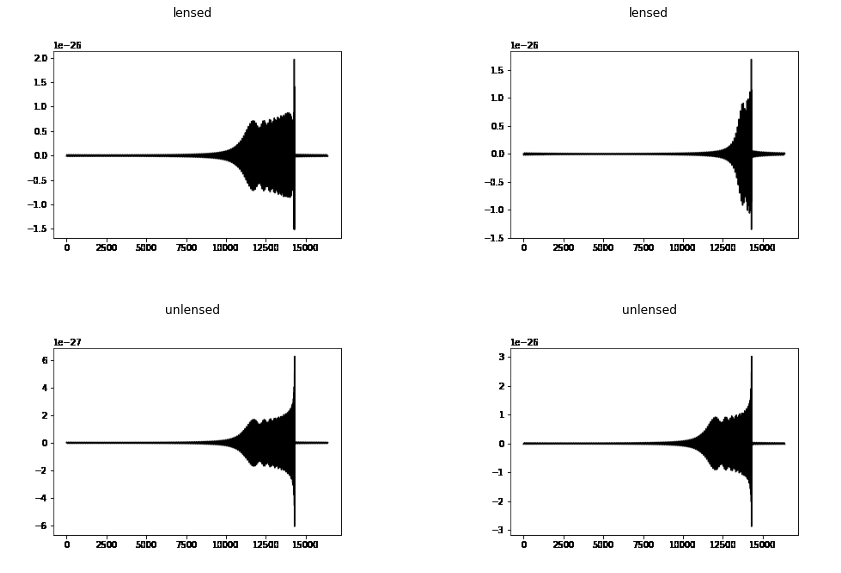

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.datasets
import matplotlib.pyplot as plt

data_path = 'data/train'

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.Normalize((0.5), (0.5)),
#     torchvision.transforms.Resize((128,128),interpolation=Image.NEAREST)
    ])

train_dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=10,
    num_workers=16,
    shuffle=True
)

test_path = "data/test"

test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=2,
    num_workers=16,
    shuffle=True
)

validate_path = "data/validate"

validate_dataset = torchvision.datasets.ImageFolder(
    root=validate_path,
    transform=transform
)
validate_loader = torch.utils.data.DataLoader(
    validate_dataset,
    batch_size=5,
    num_workers=16,
    shuffle=True
)


labels_map={1: "unlensed", 0: "lensed"}

plt.figure(figsize=(15,10))

img, label = train_dataset[0]
plt.subplot(221)
plt.axis("off")
plt.title(labels_map[label])
plt.imshow(img.squeeze(), cmap="gray")
img, label = train_dataset[1]
plt.subplot(222)
plt.axis("off")
plt.title(labels_map[label])
plt.imshow(img.squeeze(), cmap="gray")
img, label = train_dataset[4000]
plt.subplot(223)
plt.axis("off")
plt.title(labels_map[label])
plt.imshow(img.squeeze(), cmap="gray")
img, label = train_dataset[4001]
plt.subplot(224)
plt.axis("off")
plt.title(labels_map[label])
plt.imshow(img.squeeze(), cmap="gray")
# for batch_idx, (data, target) in enumerate(train_loader):
    

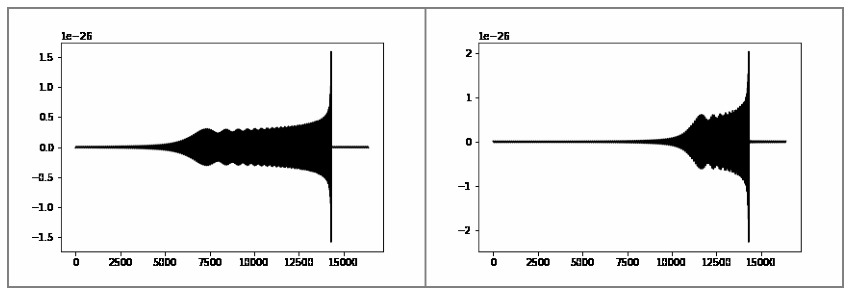

IndexError: index 2 is out of bounds for dimension 0 with size 2

In [2]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15,10))
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%s' %labels_map[labels[j].item()] for j in range(5)))

In [3]:
labels

tensor([1, 1])

In [2]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*69*105, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*69*105)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [3]:
device = torch.device("cuda:0")

In [4]:
net.to(device)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=115920, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

In [5]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.9)

In [6]:
%%time
train_accuracy = [0]
validate_accuracy = [0]
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    val_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs.squeeze().float(), labels.float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.10f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))
    with torch.no_grad():
        for data in train_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
    #         print(outputs.float)
            predicted = torch.round(outputs.squeeze().float())
    #         print(predicted)
    #         print(labels)
            c = (predicted == labels).squeeze()
    #         print(c)

            for i in range(len(c)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    train_accuracy.append(sum(class_correct)/sum(class_total))
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))
    with torch.no_grad():
        for data in validate_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
    #         print(outputs.float)
            predicted = torch.round(outputs.squeeze().float())
    #         print(predicted)
    #         print(labels)
            c = (predicted == labels).squeeze()
    #         print(c)

            for i in range(len(c)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    validate_accuracy.append(sum(class_correct)/sum(class_total))
            

print('Finished Training')

[1,   100] loss: 0.0182251049
[1,   200] loss: 0.0125196536
[1,   300] loss: 0.0122515139
[1,   400] loss: 0.0121705825
[1,   500] loss: 0.0120920314
[1,   600] loss: 0.0120678436
[1,   700] loss: 0.0119450356
[1,   800] loss: 0.0118469706
[2,   100] loss: 0.0117725885
[2,   200] loss: 0.0116821302
[2,   300] loss: 0.0116354616
[2,   400] loss: 0.0115157288
[2,   500] loss: 0.0114493830
[2,   600] loss: 0.0113617721
[2,   700] loss: 0.0112540936
[2,   800] loss: 0.0110933089
[3,   100] loss: 0.0109939721
[3,   200] loss: 0.0108761161
[3,   300] loss: 0.0107935705
[3,   400] loss: 0.0106654224
[3,   500] loss: 0.0105397983
[3,   600] loss: 0.0103716783
[3,   700] loss: 0.0103677804
[3,   800] loss: 0.0102151376
[4,   100] loss: 0.0100034324
[4,   200] loss: 0.0099051569
[4,   300] loss: 0.0097507784
[4,   400] loss: 0.0096966604
[4,   500] loss: 0.0094012014
[4,   600] loss: 0.0094007950
[4,   700] loss: 0.0093404000
[4,   800] loss: 0.0090798410
[5,   100] loss: 0.0088777499
[5,   200]

Text(0.5, 0, 'Epoch')

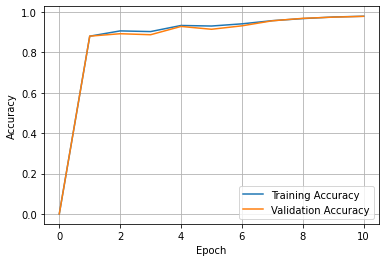

In [7]:
plt.plot(train_accuracy, label="Training Accuracy")
plt.plot(validate_accuracy, label="Validation Accuracy")
plt.legend(loc=0)
plt.grid()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

In [8]:
train_accuracy

[0,
 0.880625,
 0.90675,
 0.903375,
 0.933625,
 0.930875,
 0.94175,
 0.9575,
 0.96775,
 0.975625,
 0.979375]

In [9]:
validate_accuracy

[0,
 0.8807615230460922,
 0.8927855711422845,
 0.8877755511022044,
 0.9288577154308617,
 0.9148296593186372,
 0.9318637274549099,
 0.9569138276553106,
 0.968937875751503,
 0.9749498997995992,
 0.9789579158316634]

In [10]:
net.to(torch.device("cpu"))

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=115920, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

In [14]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
#         print(outputs.float)
        predicted = torch.round(outputs.squeeze().float())
#         print(predicted)
#         print(labels)
        c = (predicted == labels).squeeze()
#         print(c)

        for i in range(len(c)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %3f %%' % (
        labels_map[i], 100. * class_correct[i] / class_total[i]))

Accuracy of lensed : 97.205589 %
Accuracy of unlensed : 98.203593 %
